# <p style="text-align: center;">Do you need more signs?</p>

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from PIL import Image # Install Pillow -> conda install anaconda::pillow or pip install pillow
import os
from skimage.io import  imread, imshow # Install scikit-image -> conda install scikit-image or pip install scikit-image
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import re
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
from torchvision.utils import save_image 

device = torch.device("cpu")
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")

print("DEVICE: ", device)

train_dataset_path = 'data/TRAIN'
test_dataset_path = 'data/TEST'
predictions_path= 'predictions/'
results_path = 'results/'

IMG_WIDTH = 75
IMG_HEIGHT = 75
BATCH_SIZE = 32
NUM_CHANNELS = 3

DEVICE:  mps


## Data Import

In [2]:
class TestDataset(Dataset):
    def get_int(self, text):
        return [int(c) if c.isdigit() else c for c in re.split('(\d+)', text)]
    
    def __init__(self, images_folder, transform=None):
        self.images_folder = images_folder
        self.image_files = [f for f in os.listdir(images_folder) if os.path.isfile(os.path.join(images_folder, f))]
        self.image_files.sort(key=self.get_int)
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.images_folder, self.image_files[idx])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

transform = transforms.Compose([transforms.Resize((IMG_WIDTH, IMG_HEIGHT)),transforms.ToTensor()])
train_original_dataset = datasets.ImageFolder(root=train_dataset_path, transform=transform)
train_loader = DataLoader(train_original_dataset, batch_size=BATCH_SIZE, shuffle=True)

inference_dataset = TestDataset(images_folder=test_dataset_path, transform=transform)
test_loader = DataLoader(inference_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
train_size = len(train_original_dataset)
test_size = len(inference_dataset)

class_names = train_original_dataset.classes
num_classes = len(class_names)

print("Classes: ", class_names)
print("Number of classes: ", num_classes)
print("Train size: ", train_size)
print("Test size: ", test_size)

Classes:  ['12', '13', '24', '38', '39', '44', '46', '49', '50', '6']
Number of classes:  10
Train size:  277
Test size:  340


**Get the Label Mappings**

In [4]:
### subset version
#the_labels = {value for _, value in train_datagen.class_to_idx.items()}
labels = {value: key for key, value in train_original_dataset.class_to_idx.items()}
print(labels)
the_real_labels = {}
with open("data/labels.csv","r") as label_f:
    for line in label_f.readlines()[1:]:
        label_value, label_description = line.strip().split(";")
        the_real_labels[int(label_value)] = label_description 

print(the_real_labels)

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value} - {the_real_labels[int(value)]}")
the_labels_map = {key: value for key, value in train_original_dataset.class_to_idx.items()}
print(len(labels))

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}
{6: 'Speed limit (70km/h)', 12: 'Dont Go Left or Right', 13: 'Dont Go Right', 24: 'Go Right', 38: 'Dangerous right curve', 39: 'Dangerous left curve', 44: 'Go left or straight', 46: 'Zig-zag Curve', 49: 'Unknown 5', 50: 'Fences'}
Label Mappings for classes present in the training and validation datasets

0 : 12 - Dont Go Left or Right
1 : 13 - Dont Go Right
2 : 24 - Go Right
3 : 38 - Dangerous right curve
4 : 39 - Dangerous left curve
5 : 44 - Go left or straight
6 : 46 - Zig-zag Curve
7 : 49 - Unknown 5
8 : 50 - Fences
9 : 6 - Speed limit (70km/h)
10


## Initial Data Analysis

**Plotting of each available sign**

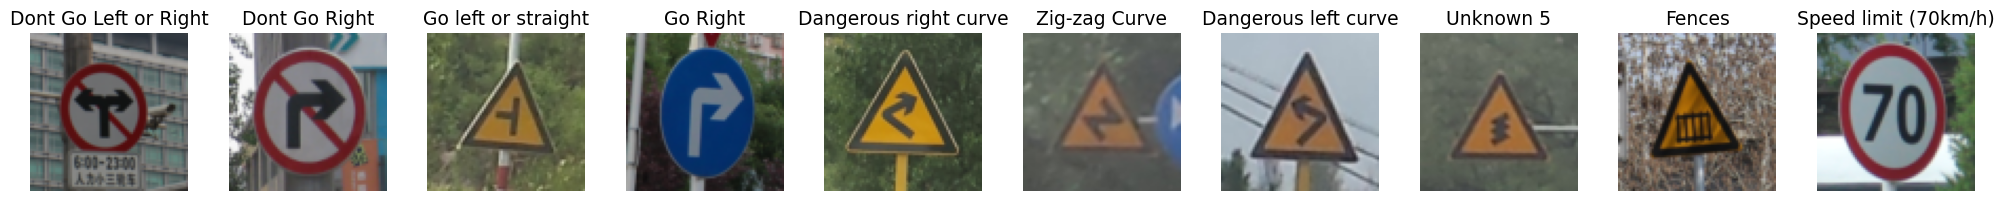

In [5]:
fig, axs = plt.subplots(1, num_classes, figsize=(2*num_classes, 2))

# Specify the new order you want
new_order = [0, 1, 5, 2, 3, 6,4, 7, 8,9]  # Adjust this list based on the actual positions you want to switch

for i, new_idx in enumerate(new_order):
    class_name = class_names[new_idx]
    # Find the first image of this class
    for img, label in train_original_dataset:
        if label == new_idx:
            axs[i].imshow(img.permute(1, 2, 0))
            axs[i].set_title(the_real_labels[int(class_name)], fontsize=13.5)
            axs[i].axis('off')
            break

plt.tight_layout()
plt.savefig(results_path + 'classes.png')
plt.show()


Corrected label from Unknown to Zig-zag Curve and Unk1 to Unkown 5 accoring to the problem statement

**Imbalance**

In [6]:
training_targets = train_original_dataset.targets
t_targets = {k:0 for k in training_targets}
for t in training_targets:
    t_targets[t] += 1
print('Training class distribution:', t_targets)

Training class distribution: {0: 12, 1: 10, 2: 8, 3: 30, 4: 34, 5: 30, 6: 9, 7: 10, 8: 56, 9: 78}


{'Speed limit (70km/h)': 78, 'Fences': 56, 'Dangerous left curve': 34, 'Dangerous right curve': 30, 'Go left or straight': 30, 'Dont Go Left or Right': 12, 'Dont Go Right': 10, 'Unknown 5': 10, 'Zig-zag Curve': 9, 'Go Right': 8}


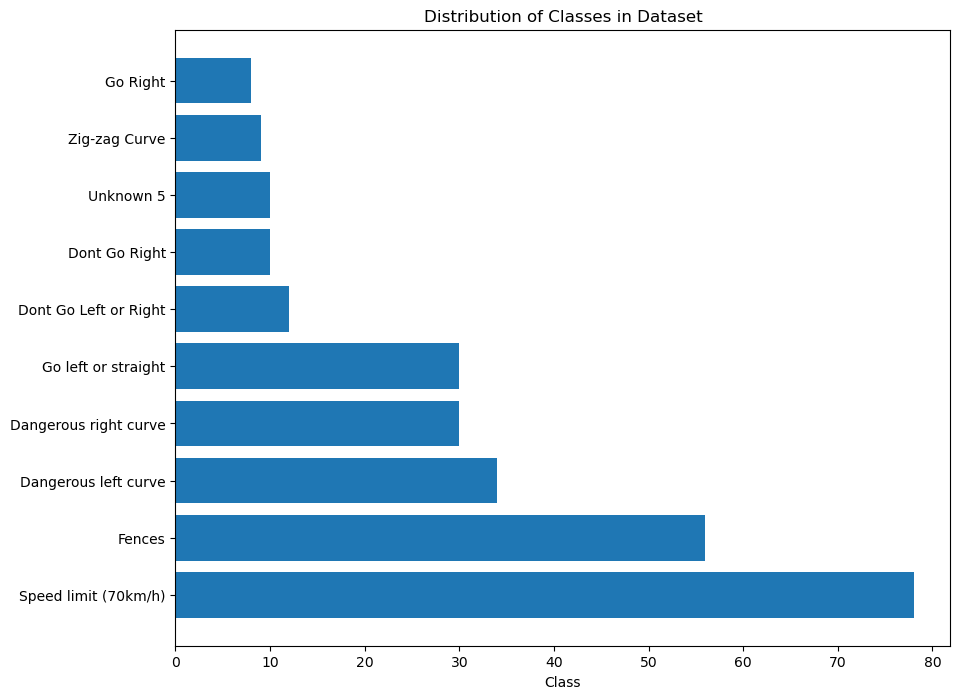

In [7]:
# Assuming train_datagen is your ImageFolder dataset
class_counts = {}
for _, label in train_original_dataset:
    class_name = train_original_dataset.classes[label]
    real_label = the_real_labels[int(class_name)]
    if real_label in class_counts:
        class_counts[real_label] += 1
    else:
        class_counts[real_label] = 1

# Sorting classes alphabetically or by count, based on your preference
class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}

print(class_counts)

# Plotting
plt.figure(figsize=(10, 8))

plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.xlabel('Class')
plt.title('Distribution of Classes in Dataset')
plt.savefig(results_path + 'class_distribution.png')
plt.show()

## Data generation
Category models should be only concern unsupervised learning due to lack of data and the need for generation

In [14]:
from torchvision.models import inception_v3
from scipy.linalg import sqrtm
from skimage.metrics import structural_similarity as ssim
from torch.autograd import Variable
from scipy.stats import entropy

results_gen_path = results_path + 'gen/'
gen_models_eval_results_path = results_gen_path + 'gen_models_eval_results.csv'

def store_gen_eval_results(model_name, eval_metrics):
    if os.path.isfile(gen_models_eval_results_path):
        # If the file exists, read it into a DataFrame
        df_gen_models_eval_results = pd.read_csv(gen_models_eval_results_path, index_col=0)
        print("CSV file found. DataFrame loaded.")
    else:
        # If the file does not exist, create a new DataFrame
        # Example: Creating a DataFrame with the specified columns and indexes
        data = {
            'Inception score': [],
            'Inception std': [],
            'FID': [],
            'SSIM': []
        }
        model_names = []  # List of model names for the index, e.g., ['model1', 'model2']
        df_gen_models_eval_results = pd.DataFrame(data, index=model_names)
        print("CSV file not found. New DataFrame created.")


    if model_name in df_gen_models_eval_results.index:
        # Update the existing row
        df_gen_models_eval_results.loc[model_name] = eval_metrics
        print(f"Updated existing model: {model_name}")
    else:
        # Append a new row
        df_gen_models_eval_results.loc[model_name] = eval_metrics
        print(f"Added new model: {model_name}")

    df_gen_models_eval_results.to_csv(gen_models_eval_results_path)
    return df_gen_models_eval_results

def calculate_ssim(real_images, fake_images):
    ssim_values = []
    real_images = real_images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    fake_images = fake_images.detach().cpu().numpy().transpose(0, 2, 3, 1)
    
    for real, fake in zip(real_images, fake_images):
        
        ssim_value = ssim(real, fake, win_size=7, multichannel=True, data_range=1.0, channel_axis=-1)
        ssim_values.append(ssim_value)
    
    return np.mean(ssim_values)

def calculate_inception_score(images, inception_model, splits=10):
    # Prepare images
    images = F.interpolate(images, size=(299, 299), mode='bilinear', align_corners=False)
    images = images.to(device)
    # Get the logits
    with torch.no_grad():
        logits = inception_model(images)
    # Compute the probabilities
    probs = F.softmax(logits, dim=1).cpu().numpy()
    
    # Split the data for evaluation
    split_scores = []
    for k in range(splits):
        part = probs[k * (len(probs) // splits): (k+1) * (len(probs) // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))
    
    return np.mean(split_scores), np.std(split_scores)

def calculate_fid(real_images, fake_images, inception_model, eps=1e-6):
    # Resize images to 299x299
    real_images = F.interpolate(real_images, size=(299, 299), mode='bilinear', align_corners=False)
    fake_images = F.interpolate(fake_images, size=(299, 299), mode='bilinear', align_corners=False)
    real_images = real_images.to(device)
    fake_images = fake_images.to(device)
    
    # Get the activations
    with torch.no_grad():
        act1 = inception_model(real_images).cpu().numpy()
        act2 = inception_model(fake_images).cpu().numpy()
    
    # Calculate mean and covariance statistics
    mu1, sigma1 = np.mean(act1, axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = np.mean(act2, axis=0), np.cov(act2, rowvar=False)
    
    # Add a small epsilon to the diagonal to prevent numerical instability
    sigma1 += np.eye(sigma1.shape[0]) * eps
    sigma2 += np.eye(sigma2.shape[0]) * eps

    # Calculate FID
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary component from sqrtm
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid


def plot_accuracy_loss(train_losses, val_losses, num_epochs, path_name):

    plt.figure(figsize=(12, 5))
    plt.title('Loss Analysis', fontsize=16)

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, train_losses, label='Training')
    plt.plot(epochs, val_losses, label='Validation')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xticks(epochs)
    plt.xlim(1, num_epochs)

    plt.tight_layout()
    plt.savefig(path_name + '_loss_analysis.png')
    plt.show()

def plot_loss_D_G(losses_D, losses_G, num_epochs, path_name):

    plt.figure(figsize=(12, 5))
    plt.title('Loss Analysis', fontsize=16)

    epochs = range(1, num_epochs + 1)
    plt.plot(epochs, losses_D, label='Discriminator')
    plt.plot(epochs, losses_G, label='Generator')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.xlim(1, num_epochs)

    plt.tight_layout()
    plt.savefig(path_name + '_loss_analysis.png')
    plt.show()

def plot_generated_inspection(real, fake, results_path, color_channels=NUM_CHANNELS, width=IMG_WIDTH, height=IMG_HEIGHT):
    plt.figure(figsize=(9, 2))
    plt.gray()
    # imgs = outputs[k][1].detach().numpy()
    # recon = outputs[k][2].detach().numpy()
    imgs = real.cpu().detach().numpy()
    recon = fake.cpu().detach().numpy()
    
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.axis('off')

        if color_channels == 1:
            item = np.clip(item, 0.0, 1.0)
            plt.imshow(item.reshape(height, width))
        else:
            item = item.reshape(color_channels,height, width)
            item = np.clip(item, 0.0, 1.0)
            plt.imshow(np.transpose(item, (1,2,0)))

    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        
        plt.axis('off')
        if color_channels == 1:
            item = np.clip(item, 0.0, 1.0)
            plt.imshow(item.reshape(height, width))
        else:
            item = item.reshape(color_channels,height, width)
            item = np.clip(item, 0.0, 1.0)
            plt.imshow(np.transpose(item, (1,2,0)))
    plt.savefig(results_path + '_val_real_fake_comparison.png')

### Auto-encoders

In [102]:
class Autoencoder(nn.Module):
    def __init__(self, color_channels=3, width=IMG_WIDTH, height=IMG_HEIGHT):
        super().__init__()
        self.encoder=nn.Sequential(
            nn.Conv2d(color_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.Conv2d(32, 4, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            )
        
        self.decoder=nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, color_channels, kernel_size=3, stride=1,padding=1),
            nn.SELU()
            )
        
    def forward(self,x):
        encoded=self.encoder(x)
        decoded=self.decoder(encoded)
        return decoded

from torchvision.utils import save_image

def train_autoencoder(model, criterion, optimizer, data_loader, num_epochs=50, device='cpu'):

    train_losses=[]
    example_output=0
    real_images = []
    gen_images = []
    saved_gen_img_ind = 0
    model = model.to(device)

    for epoch in range(num_epochs):
        
        cumulative_loss = 0
        for batch_idx, (images, labels) in enumerate(data_loader):

            images=images.to(device)
            recon=model(images)
            
            if epoch == num_epochs - 1:
                real_images.append(images.cpu())
                gen_images.append(recon.cpu())

                for i in range(len(labels)):

                    class_label = data_loader.dataset.classes[labels[i]]
                    class_dir = os.path.join(AE_gen_dataset_path, class_label)
                    os.makedirs(class_dir, exist_ok=True)
                    save_image(recon[i], f"{class_dir}/generated_image_{saved_gen_img_ind}.png")
                    saved_gen_img_ind += 1

            loss=criterion(recon, images)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            cumulative_loss += loss.item()

        loss = cumulative_loss / len(data_loader)
        train_losses.append(loss)

        if epoch == num_epochs - 1:
            example_output = (images, recon)

        print(f'Epoch:{epoch+1}, Cumulative average Loss:{loss}')

     # Concatenate all batches
    real_images = torch.cat(real_images, dim=0)
    gen_images = torch.cat(gen_images, dim=0)

    # Compute metrics
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()

    inception_mean, inception_std = calculate_inception_score(gen_images, inception_model)
    print(f'Inception Score: {inception_mean} +- {inception_std}')
    fid = calculate_fid(real_images, gen_images, inception_model)
    print(f'FID: {fid}')
    ssim = calculate_ssim(real_images, gen_images)
    print(f'SSIM: {ssim}')

    eval_metrics = [inception_mean, inception_std, fid, ssim]
        
    return model.to('cpu'), real_images, gen_images, example_output, train_losses, eval_metrics

AE_gen_dataset_path = 'data/AE_GEN/'

**WHEN TO TRAIN THE MODEL AGAIN, FIRST DELETE FOLDER WITH THE GENERATED DATA OR IT WILL ACCUMULATE**

In [103]:
from torch import optim

AE_model=Autoencoder()
model_name = 'AE'
criterion = nn.L1Loss()
optimizer = optim.Adam(AE_model.parameters(),
                                lr=1e-3, 
                                weight_decay=1e-5)
num_epochs=25

AE_model,real_images, gen_images, example_output, train_losses, eval_metrics = train_autoencoder(AE_model, criterion, optimizer, train_loader, num_epochs, device)

Epoch:1, Cumulative average Loss:0.3914820883009169
Epoch:2, Cumulative average Loss:0.14803381098641288
Epoch:3, Cumulative average Loss:0.12865377879805034
Epoch:4, Cumulative average Loss:0.10927851415342754
Epoch:5, Cumulative average Loss:0.0914669210712115
Epoch:6, Cumulative average Loss:0.08343262390957938
Epoch:7, Cumulative average Loss:0.07915720095237096
Epoch:8, Cumulative average Loss:0.07481263412369622
Epoch:9, Cumulative average Loss:0.06948344823386934
Epoch:10, Cumulative average Loss:0.06567604301704301
Epoch:11, Cumulative average Loss:0.06261035303274791
Epoch:12, Cumulative average Loss:0.06172762728399701
Epoch:13, Cumulative average Loss:0.058778729703691274
Epoch:14, Cumulative average Loss:0.05607562967472606
Epoch:15, Cumulative average Loss:0.05197628132171101
Epoch:16, Cumulative average Loss:0.04716722004943424
Epoch:17, Cumulative average Loss:0.04346084967255592
Epoch:18, Cumulative average Loss:0.04070760392480426
Epoch:19, Cumulative average Loss:0.03

/Users/alex/miniconda3/envs/aca2024/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alex/miniconda3/envs/aca2024/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Inception Score: 2.5491185188293457 +- 0.18744239211082458
FID: 305.8388639548141
SSIM: 0.9066548347473145


**Evaluation Metrics**

In [104]:
df_gen_models_eval_results = store_gen_eval_results(model_name, eval_metrics)
df_gen_models_eval_results

CSV file found. DataFrame loaded.
Updated existing model: AE


,Inception score,Inception std,FID,SSIM
AE,2.549119,0.187442,305.838864,0.906655


**Visual Inspection**

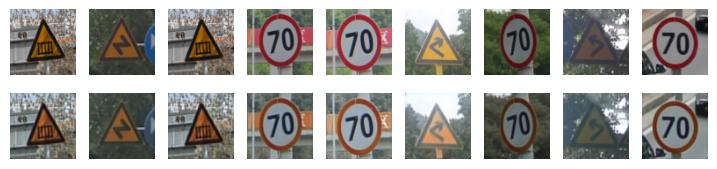

In [55]:
plot_generated_inspection(example_output, results_gen_path + model_name)

### GANs

- **Evaluation**: To ensure high-quality traffic sign images generated by GANs, we implement a rigorous methodology combining qualitative and quantitative evaluations. First, we generate a batch of images and conduct a thorough visual inspection, identifying artifacts, distortions, or unrealistic features. Any low-quality images are discarded. Quantitatively, we use metrics such as Inception Score (IS), Fréchet Inception Distance (FID), and Precision/Recall to objectively assess image quality and diversity. We document common issues, such as incorrect colors or shapes, and provide detailed feedback for model refinement. Adjustments to the GAN architecture, training parameters, or dataset are made based on this feedback. The refined model is then retrained, and the process is repeated iteratively. This approach ensures that the generated images are both realistic and diverse, enhancing the performance of traffic sign classifiers. By combining visual assessment with iterative improvements and quantitative metrics, we maintain high standards in the generated data, crucial for effective machine learning model training and deployment.

- In a conditional GAN, the label embeddings are concatenated with the image inputs because this allows the discriminator to use the label information when making its decision about whether an image is real or fake. The generator also uses label information to generate images conditioned on specific labels. The convolutional neural networks (CNNs) process these concatenated inputs to learn the dependencies between the labels and the images.

In [10]:
class Generator(nn.Module):
    def __init__(self, nz, num_classes = num_classes,num_channels=NUM_CHANNELS):
        super(Generator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, nz)
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz*2, 512, kernel_size=4, stride=1, padding=0, bias=False),  # 1x1 -> 4x4
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),  # 4x4 -> 8x8
            nn.BatchNorm2d(256), 
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),  # 8x8 -> 16x16
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),  # 16x16 -> 32x32
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, num_channels, kernel_size=4, stride=2, padding=1, bias=False),  # 32x32 -> 64x64
            nn.Tanh()
        )

    def forward(self,noise, labels):
        label_emb = self.label_emb(labels).view(labels.size(0), -1, 1, 1)
        gen_input = torch.cat((noise, label_emb), dim=1)
        x = self.main(gen_input)
        x = F.interpolate(x, size=(75, 75), mode='bilinear', align_corners=True)
        return x

class Discriminator(nn.Module):
    def __init__(self,num_classes = num_classes, num_channels = NUM_CHANNELS):
        super(Discriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_channels * 75 * 75)
        self.main = nn.Sequential(
            nn.Conv2d(num_channels*2, 64, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, kernel_size=4, stride=2, padding=0, bias=False), 
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        batch_size = img.size(0)
        label_emb = self.label_emb(labels).view(batch_size,3, 75, 75)
        d_in = torch.cat((img, label_emb), dim=1)
        return self.main(d_in).view(-1)
    
model_name = 'DCGAN'
DCGAN_gen_dataset_path = 'data/DC-GAN_GEN/'

nz = 100

netG = Generator(nz).to(device)
netD = Discriminator().to(device)

optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Test with a dummy input to verify output shape
noise = torch.randn(BATCH_SIZE, nz, 1, 1, device=device)
labels = torch.randint(0, num_classes, (BATCH_SIZE,), device=device)
fake_images = netG(noise, labels)
print("Generator output size:", fake_images.size())  # Should be [32, 3, 75, 75]

Generator output size: torch.Size([32, 3, 75, 75])


**Training loop**

In [11]:
criterion = nn.BCELoss()

real_label=1
fake_label=0
num_epochs=250

example_output = 0

losses_D = []
losses_G = []

real_images_list = []
fake_images_list = []

train_loader_size = len(train_loader)

for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")

    loss_D = 0.0
    loss_G = 0.0


    for i, (real_data, real_labels) in enumerate(train_loader):
        
        real_data = real_data.to(device)
        real_labels = real_labels.to(device,dtype=torch.long)
        batch_size = real_data.size(0)

        # Real Batch através do Discriminator
        netD.zero_grad()
        output_real = netD(real_data, real_labels)
        label_real = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
        loss_real = criterion(output_real, label_real)
        loss_real.backward()

        # Generate fake images and train Discriminator with fake images
        noise = torch.randn(batch_size, nz, 1, 1, device=device)
        fake_labels = torch.randint(0, num_classes, (batch_size,), device=device)
        fake_images = netG(noise, fake_labels)
        output_fake = netD(fake_images.detach(), fake_labels)
        label_fake = torch.full((batch_size,), fake_label, dtype=torch.float, device=device)
        loss_fake = criterion(output_fake, label_fake)
        loss_fake.backward()  
        optimizerD.step()

        # Calculate and store discriminator loss
        loss_D += (loss_real.item() + loss_fake.item())

        # Train Generator
        netG.zero_grad()
        output_fake = netD(fake_images, fake_labels)
        loss_gen = criterion(output_fake, label_real)  # Fake labels are real for generator cost
        loss_gen.backward()
        optimizerG.step()

        # Store generator loss
        loss_G += loss_gen.item()

        # Save real and fake images from the last epoch
        if epoch == num_epochs - 1:
            real_images_list.append(real_data.cpu())
            fake_images_list.append(fake_images.cpu())

    # Calculate and store average losses for the epoch
    losses_D.append(loss_D / train_loader_size)
    losses_G.append(loss_G / train_loader_size)
            

Epoch 1/250
Epoch 2/250
Epoch 3/250
Epoch 4/250
Epoch 5/250
Epoch 6/250
Epoch 7/250
Epoch 8/250
Epoch 9/250
Epoch 10/250
Epoch 11/250
Epoch 12/250
Epoch 13/250
Epoch 14/250
Epoch 15/250
Epoch 16/250
Epoch 17/250
Epoch 18/250
Epoch 19/250
Epoch 20/250
Epoch 21/250
Epoch 22/250
Epoch 23/250
Epoch 24/250
Epoch 25/250
Epoch 26/250
Epoch 27/250
Epoch 28/250
Epoch 29/250
Epoch 30/250
Epoch 31/250
Epoch 32/250
Epoch 33/250
Epoch 34/250
Epoch 35/250
Epoch 36/250
Epoch 37/250
Epoch 38/250
Epoch 39/250
Epoch 40/250
Epoch 41/250
Epoch 42/250
Epoch 43/250
Epoch 44/250
Epoch 45/250
Epoch 46/250
Epoch 47/250
Epoch 48/250
Epoch 49/250
Epoch 50/250
Epoch 51/250
Epoch 52/250
Epoch 53/250
Epoch 54/250
Epoch 55/250
Epoch 56/250
Epoch 57/250
Epoch 58/250
Epoch 59/250
Epoch 60/250
Epoch 61/250
Epoch 62/250
Epoch 63/250
Epoch 64/250
Epoch 65/250
Epoch 66/250
Epoch 67/250
Epoch 68/250
Epoch 69/250
Epoch 70/250
Epoch 71/250
Epoch 72/250
Epoch 73/250
Epoch 74/250
Epoch 75/250
Epoch 76/250
Epoch 77/250
Epoch 78

**Visual Inspection**

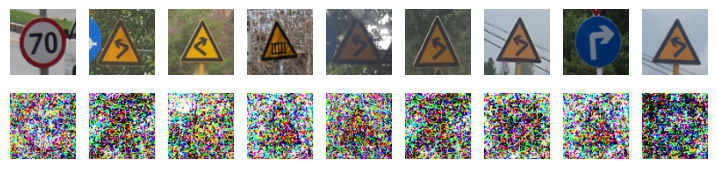

In [15]:
real_images_last_epoch = torch.cat(real_images_list, dim=0)
fake_images_last_epoch = torch.cat(fake_images_list, dim=0)

plot_generated_inspection(real_images_last_epoch,fake_images_last_epoch, results_gen_path + model_name)

**Loss Analysis**

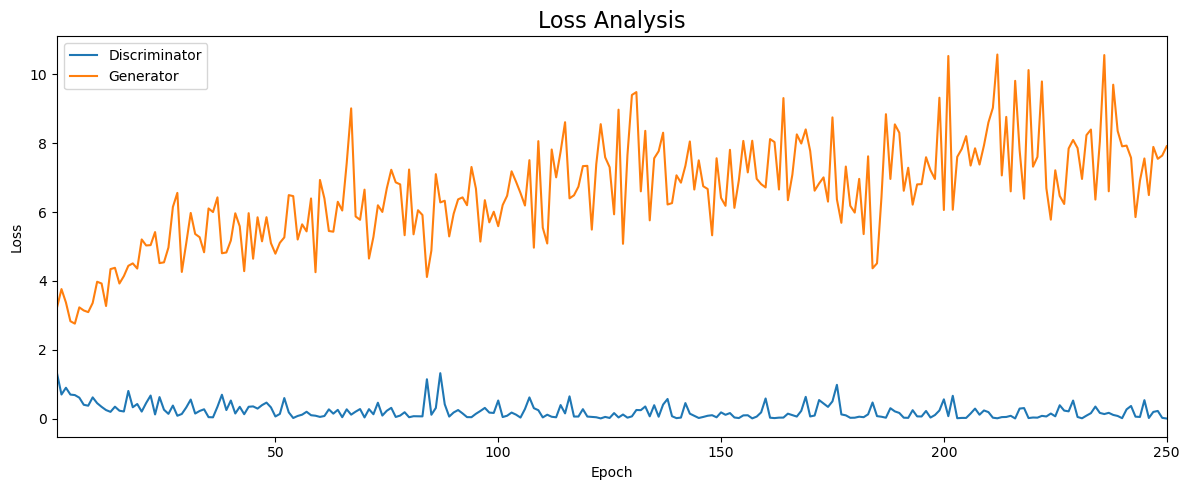

In [16]:
plot_loss_D_G(losses_D, losses_G, num_epochs, results_gen_path + model_name)

**Generation & Evaluation**

In [17]:
def evaluate_gan_by_class(generator, data_loader, save_gen_img = False, num_images_per_class = 100,batch_size = BATCH_SIZE, num_classes = num_classes, device = device):
    
    inception_model = inception_v3(pretrained=True, transform_input=False).to(device)
    inception_model.eval()
    
    generator.eval()
    
    ssim_all = []
    inception_all = []
    fid_all = []

    saved_gen_img_ind = 0

    for class_label in range(num_classes):
        print(f"Evaluating class {class_label}...")
        
        real_images = []
        fake_images = []
        
        # Collect real images of the current class
        for i, (real_imgs, real_labels) in enumerate(data_loader):
            class_mask = (real_labels == class_label)
            real_images.append(real_imgs[class_mask])

        real_images = torch.cat(real_images)
        num_real_images = len(real_images)

        print(f"Collected {num_real_images} real images for class {class_label}.")

        # Duplicate real images to match the target number of images
        if num_real_images < num_images_per_class:
            real_images = real_images.repeat((num_images_per_class // num_real_images) + 1, 1, 1, 1)

        real_images = real_images[:num_images_per_class]
        # Generate fake images
        with torch.no_grad():
            while len(fake_images) < num_images_per_class:
                noise = torch.randn(batch_size, nz, 1, 1, device=device)
                labels = torch.full((batch_size,), class_label, device=device, dtype=torch.long)
                fake_imgs = generator(noise, labels)
                fake_images.append(fake_imgs)
        
        fake_images = torch.cat(fake_images)[:num_images_per_class]

        # Calculate metrics for the current class
        ssim_value = calculate_ssim(real_images, fake_images)
        inception_mean, inception_std = calculate_inception_score(fake_images, inception_model)
        fid_value = calculate_fid(real_images, fake_images, inception_model)

        ssim_all.append(ssim_value)
        inception_all.append(inception_mean)
        fid_all.append(fid_value)

        # Save generated images to appropriate class directories
        if save_gen_img:

            class_real_label = data_loader.dataset.classes[labels[i]]
            class_dir = os.path.join(DCGAN_gen_dataset_path, f'{class_real_label}')
            os.makedirs(class_dir, exist_ok=True)
            for i, img in enumerate(fake_images):
                save_image(img, os.path.join(class_dir, f'GAN_image_{saved_gen_img_ind}.png'))
                saved_gen_img_ind += 1

        
    return np.mean(ssim_all), np.mean(inception_all), np.mean(fid_all)


ssim, inception, fid = evaluate_gan_by_class(netG, train_loader, True)
print(f"SSIM: {ssim}")
print(f"Inception Score: {inception}")
print(f"FID: {fid}")

/Users/alex/miniconda3/envs/aca2024/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/alex/miniconda3/envs/aca2024/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Evaluating class 0...
Collected 12 real images for class 0.
Evaluating class 1...
Collected 10 real images for class 1.
Evaluating class 2...
Collected 8 real images for class 2.
Evaluating class 3...
Collected 30 real images for class 3.
Evaluating class 4...
Collected 34 real images for class 4.
Evaluating class 5...
Collected 30 real images for class 5.
Evaluating class 6...
Collected 9 real images for class 6.
Evaluating class 7...
Collected 10 real images for class 7.
Evaluating class 8...
Collected 56 real images for class 8.
Evaluating class 9...
Collected 78 real images for class 9.
SSIM: 0.01712578535079956
Inception Score: 1.0007238388061523
FID: 1886.1655705134326


## Model Training
- No cross-validation is used. Since the baseline model is in a file it means it's already been trained on the non-augmented train set. Thus implementing cross-validation would not lead to fair results.
- Same thing goes for the data split it should be always equal

In [18]:
class CustomCNN(nn.Module):
    def __init__(self, img_width, img_height, num_classes):
        super(CustomCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=128, kernel_size=5, padding='valid')
        self.bn1 = nn.BatchNorm2d(num_features=128)
        
        self.conv2 = nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding='valid', bias=False)
        self.bn2 = nn.BatchNorm2d(num_features=64)
        
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=32, kernel_size=3, padding='valid', bias=False)
        self.bn3 = nn.BatchNorm2d(num_features=32)
        
        #self.fc1 = nn.Linear(32 * self._conv_output_shape(img_width, img_height), 256)  # Assuming square input for simplification
        self.fc1 = nn.Linear(1568,256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)
        
        # L2 regularization is not directly included in layers in PyTorch, 
        # it's typically added to the optimizer during the training step.

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, kernel_size=2)
        
        x = torch.flatten(x, 1)  # Flatten all dimensions except batch
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x
    
    def _conv_output_shape(self, img_width, img_height, kernel_size=3, stride=1, padding=0, dilation=1):
        h = ((img_height + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        w = ((img_width + (2 * padding) - (dilation * (kernel_size - 1)) - 1) / stride) + 1
        return int(h/8) * int(w/8)  # Considering three max pooling layers with kernel_size=2, stride=2


In [19]:
results_baseline_path = results_path + 'baseline/'

def train_model(model, criterion, optimizer,train_dataset_loader, num_epochs=10, device='cpu'):
    model.to(device)
    train_loss = []
    for epoch in range(num_epochs):
        cumulative_loss = 0
        for batch_idx, (data, target) in enumerate(train_dataset_loader):

            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            #if (batch_idx + 1) % 100 == 0:
            print(f'Epoch {epoch+1}/{num_epochs}, Step {batch_idx+1}/{len(train_dataset_loader)}, Loss: {loss.item():.4f}')
            cumulative_loss += loss.item()
        
        cumulative_avg_loss = cumulative_loss/len(train_dataset_loader)

        train_loss.append(cumulative_avg_loss)
        print(f"Epoch {epoch+1} average loss: {cumulative_avg_loss}")
    
    return model.to("cpu"), train_loss

def train_eval_model(model, criterion, optimizer,train_loader,val_loader, num_epochs=10, device='cpu'):

    model.to(device)
    train_losses = []
    val_losses = []

    last_y_real = []
    last_y_pred = []

    for epoch in range(num_epochs):

        cumulative_loss = 0

        for images, labels in train_loader:

            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            cumulative_loss += loss.item()
        
        cumulative_loss = cumulative_loss/len(train_loader)
        train_losses.append(cumulative_loss)

        val_loss = 0
        model.eval()

        with torch.no_grad():

            for images, labels in val_loader:

                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()

                if epoch == num_epochs - 1:

                    last_y_real.extend(labels.cpu().numpy())
                    _, predicted = torch.max(outputs.data, 1)
                    last_y_pred.extend(predicted.cpu().numpy())

        val_loss = val_loss / len(val_loader)  # Compute average validation loss
        val_losses.append(val_loss)
    
        print(f"Epoch {epoch+1} average loss: {cumulative_loss}\t Validation loss: {val_loss}")

    return model.to("cpu"), train_losses, val_losses, last_y_real, last_y_pred

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, roc_auc_score

def evaluation_metrics(target,pred,average='weighted'):
    # Convert target and probs to suitable numpy arrays if not already
    
    precision, recall, f1, _ = precision_recall_fscore_support(target, pred, average=average)
    accuracy = accuracy_score(target, pred)
    cm = confusion_matrix(target, pred)
    
    return precision, recall, f1, cm, accuracy

**Train set selection**
- 0: Original
- 1: Auto-encoder
- 2: GAN
- 3: Diffusion 

**Data Split**
- But if we go for the data splti which has shuffle true it means that the test set will always be different and the results will be different. This for the customCNN it can be trained and the same fgo
- Confused with the data split for the rest
- 

In [20]:
class CombinedDataset(Dataset):
    def __init__(self, original_dataset, generated_dataset):
        self.original_dataset = original_dataset
        self.generated_dataset = generated_dataset
        self.length = len(self.original_dataset) + len(self.generated_dataset)
        self.classes = original_dataset.classes  # Assuming both datasets have the same classes

        # Combine the targets
        self.targets = np.concatenate((original_dataset.targets, generated_dataset.targets))

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        if idx < len(self.original_dataset):
            return self.original_dataset[idx]
        else:
            idx -= len(self.original_dataset)
            return self.generated_dataset[idx]

train_data_selection = 2

#baseline + AE
if train_data_selection == 1:
    # Load the generated images dataset
    train_AE_generated_dataset = datasets.ImageFolder(root=AE_gen_dataset_path, transform=transform)
    train_set = CombinedDataset(train_original_dataset, train_AE_generated_dataset)
    dataset_name = "Baseline_AE"

#baseline + GAN
elif train_data_selection == 2:
    train_GAN_generated_dataset = datasets.ImageFolder(root=DCGAN_gen_dataset_path, transform=transform)
    train_set = CombinedDataset(train_original_dataset, train_GAN_generated_dataset)
    dataset_name = "Baseline_DCGAN"
#baseline
else:
    train_set = train_original_dataset
    dataset_name = "Baseline"


print("Train size: ", len(train_set))


Train size:  1277


{'Speed limit (70km/h)': 178, 'Fences': 156, 'Dangerous left curve': 134, 'Dangerous right curve': 130, 'Go left or straight': 130, 'Dont Go Left or Right': 112, 'Dont Go Right': 110, 'Unknown 5': 110, 'Zig-zag Curve': 109, 'Go Right': 108}


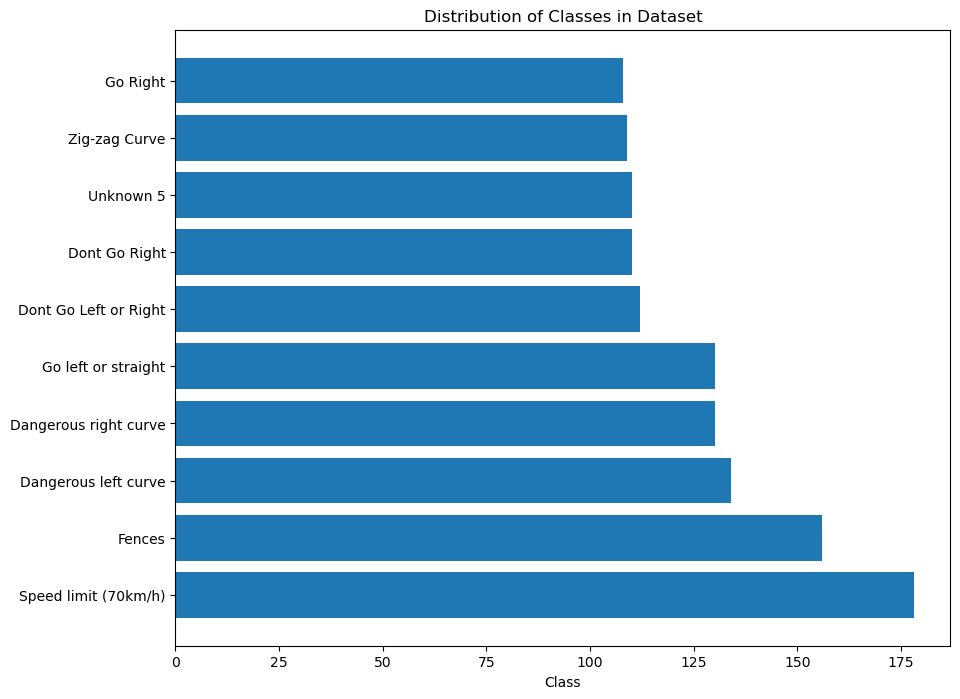

In [26]:
# Assuming train_datagen is your ImageFolder dataset
class_counts = {}
for _, label in train_set:
    class_name = train_set.classes[label]
    real_label = the_real_labels[int(class_name)]
    if real_label in class_counts:
        class_counts[real_label] += 1
    else:
        class_counts[real_label] = 1

# Sorting classes alphabetically or by count, based on your preference
class_counts = {k: v for k, v in sorted(class_counts.items(), key=lambda item: item[1], reverse=True)}
print(class_counts)

# Plotting
plt.figure(figsize=(10, 8))

plt.barh(list(class_counts.keys()), list(class_counts.values()))
plt.xlabel('Class')
plt.title('Distribution of Classes in Dataset')
plt.savefig(results_baseline_path + dataset_name+'_class_distribution.png')
plt.show()

In [27]:
train_idx, valid_idx = train_test_split(
    range(len(train_set)),
    test_size=0.1,
    shuffle=True,
    stratify=train_set.targets
)

print("Train size: ", len(train_idx))
print("Validation size: ", len(valid_idx))

train_subset = Subset(train_set, train_idx)
valid_subset = Subset(train_set, valid_idx)

train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(valid_subset, batch_size=BATCH_SIZE, shuffle=False)

Train size:  1149
Validation size:  128


In [28]:
TRAIN_MODEL = True

if TRAIN_MODEL:
    
    num_epochs = 30
    model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    ccnn,train_losses,val_losses, y_real,y_pred = train_eval_model(model, criterion, optimizer, train_loader,val_loader, num_epochs, device)
    precision, recall, f1, cm, accuracy = evaluation_metrics(y_real, y_pred)
    
else:
    ccnn = torch.load('baseline_model.pth')
    dataset_name = "baseline"

Epoch 1 average loss: 1.1388540243109067	 Validation loss: 0.668170839548111
Epoch 2 average loss: 0.3802572757833534	 Validation loss: 0.32510413974523544
Epoch 3 average loss: 0.2421244459433688	 Validation loss: 0.22449596226215363
Epoch 4 average loss: 0.18384258734941897	 Validation loss: 0.1838881690055132
Epoch 5 average loss: 0.14701075117207235	 Validation loss: 0.17779933847486973
Epoch 6 average loss: 0.12328692310903636	 Validation loss: 0.1683738986030221
Epoch 7 average loss: 0.09538959114191432	 Validation loss: 0.1295500067062676
Epoch 8 average loss: 0.07873708379661871	 Validation loss: 0.13376964023336768
Epoch 9 average loss: 0.0683004188661774	 Validation loss: 0.09913517511449754
Epoch 10 average loss: 0.05510187008055962	 Validation loss: 0.08923796215094626
Epoch 11 average loss: 0.04170350266698127	 Validation loss: 0.1265443677548319
Epoch 12 average loss: 0.05029871527545361	 Validation loss: 0.08956391649553552
Epoch 13 average loss: 0.040512286063555315	 Va

## Validation results analysis

In [31]:
model_evaluation_results_file_path = results_baseline_path+ 'model_evaluation_results_training_datasets.csv'

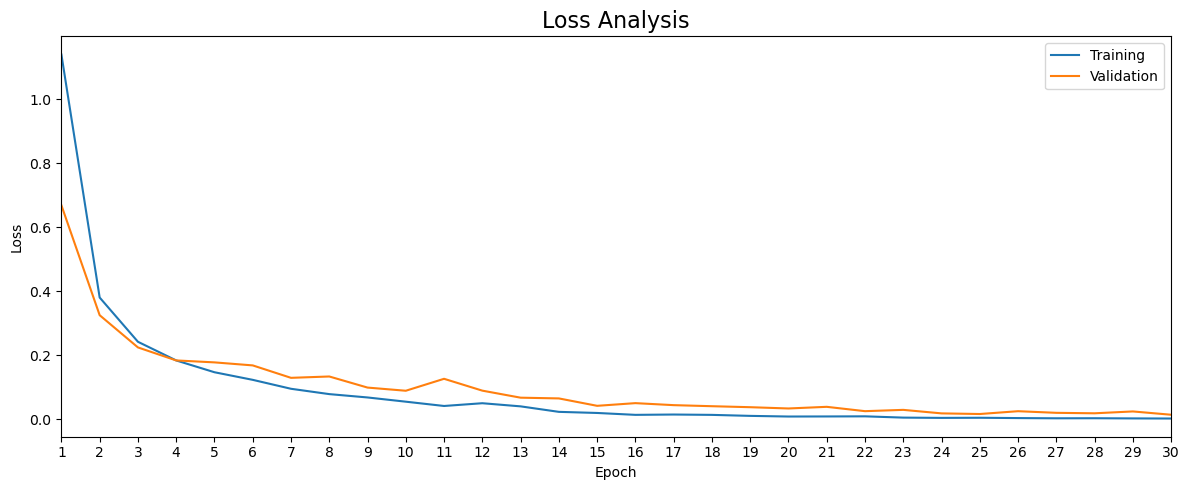

In [32]:
plot_accuracy_loss(train_losses, val_losses, num_epochs, results_baseline_path + dataset_name)

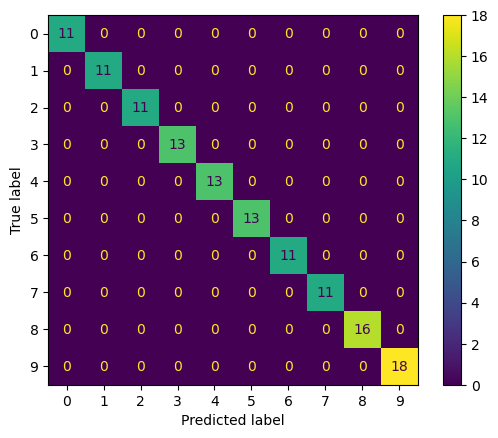

In [33]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.savefig(results_baseline_path + f'{dataset_name}_confusion_matrix.png')
plt.show()

In [34]:
if os.path.isfile(model_evaluation_results_file_path):
    # If the file exists, read it into a DataFrame
    df_model_train_eval_results = pd.read_csv(model_evaluation_results_file_path, index_col=0)
    print("CSV file found. DataFrame loaded.")
else:
    # If the file does not exist, create a new DataFrame
    # Example: Creating a DataFrame with the specified columns and indexes
    data = {
        'precision': [],
        'recall': [],
        'f1': [],
        'accuracy': []
    }
    model_names = []  # List of model names for the index, e.g., ['model1', 'model2']
    df_model_train_eval_results = pd.DataFrame(data, index=model_names)
    print("CSV file not found. New DataFrame created.")


if dataset_name in df_model_train_eval_results.index:
    # Update the existing row
    df_model_train_eval_results.loc[dataset_name] = [precision, recall, f1, accuracy]
    print(f"Updated existing model: {dataset_name}")
else:
    # Append a new row
    df_model_train_eval_results.loc[dataset_name] = [precision, recall, f1, accuracy]
    print(f"Added new model: {dataset_name}")

df_model_train_eval_results.to_csv(model_evaluation_results_file_path)
df_model_train_eval_results

CSV file found. DataFrame loaded.
Updated existing model: Baseline_DCGAN


,precision,recall,f1,accuracy
Baseline,0.081633,0.285714,0.126984,0.285714
Baseline_AE,1.000000,1.000000,1.000000,1.000000
Baseline_DCGAN,1.000000,1.000000,1.000000,1.000000


## Prediction

In [35]:
#baseline + AE
if train_data_selection == 1:
    # Load the generated images dataset
    train_AE_generated_dataset = datasets.ImageFolder(root=AE_gen_dataset_path, transform=transform)
    train_set = CombinedDataset(train_original_dataset, train_AE_generated_dataset)
    dataset_name = "Baseline_AE"

#baseline + GAN
elif train_data_selection == 2:
    train_GAN_generated_dataset = datasets.ImageFolder(root=DCGAN_gen_dataset_path, transform=transform)
    train_set = CombinedDataset(train_original_dataset, train_GAN_generated_dataset)
    dataset_name = "Baseline_DCGAN"
#baseline
else:
    train_set = train_original_dataset
    dataset_name = "Baseline"

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False)

num_epochs = 30
model = CustomCNN(IMG_WIDTH, IMG_HEIGHT, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
ccnn,train_loss = train_model(model, criterion, optimizer, train_loader, num_epochs, device)

Epoch 1/30, Step 1/40, Loss: 2.4743
Epoch 1/30, Step 2/40, Loss: 2.1363
Epoch 1/30, Step 3/40, Loss: 2.7785
Epoch 1/30, Step 4/40, Loss: 2.6677
Epoch 1/30, Step 5/40, Loss: 2.3001
Epoch 1/30, Step 6/40, Loss: 2.1008
Epoch 1/30, Step 7/40, Loss: 2.1851
Epoch 1/30, Step 8/40, Loss: 2.3283
Epoch 1/30, Step 9/40, Loss: 2.2160
Epoch 1/30, Step 10/40, Loss: 2.3189
Epoch 1/30, Step 11/40, Loss: 1.6262
Epoch 1/30, Step 12/40, Loss: 1.4766
Epoch 1/30, Step 13/40, Loss: 2.8648
Epoch 1/30, Step 14/40, Loss: 2.0362
Epoch 1/30, Step 15/40, Loss: 1.3999
Epoch 1/30, Step 16/40, Loss: 3.2365
Epoch 1/30, Step 17/40, Loss: 2.6197
Epoch 1/30, Step 18/40, Loss: 1.9448
Epoch 1/30, Step 19/40, Loss: 2.9675
Epoch 1/30, Step 20/40, Loss: 2.4892
Epoch 1/30, Step 21/40, Loss: 1.7558
Epoch 1/30, Step 22/40, Loss: 3.2095
Epoch 1/30, Step 23/40, Loss: 3.1371
Epoch 1/30, Step 24/40, Loss: 2.2186
Epoch 1/30, Step 25/40, Loss: 2.9250
Epoch 1/30, Step 26/40, Loss: 3.2031
Epoch 1/30, Step 27/40, Loss: 2.5194
Epoch 1/30

In [36]:
image_ids = range(1, test_size+1)

labels = {value: key for key, value in train_original_dataset.class_to_idx.items()}
print(labels)

def model_prediction(model,test_loader,dataset_name,device):
    model.to(device)
    model.eval()
    predictions = []

    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            # Assuming you're interested in the highest probability class
            _, predicted_labels = torch.max(outputs, 1)
            predictions.extend(predicted_labels.cpu().numpy())
    real_labels_predictions = [int(labels[p]) for p in predictions]   
    print(real_labels_predictions) 
    prediction_df = pd.DataFrame({
        'ID': image_ids,
        'Class': real_labels_predictions
    })
    prediction_df.to_csv(f'{predictions_path}{dataset_name}.csv', index=False)

{0: '12', 1: '13', 2: '24', 3: '38', 4: '39', 5: '44', 6: '46', 7: '49', 8: '50', 9: '6'}


In [37]:
model_prediction(ccnn,test_loader,dataset_name,device)

[6, 49, 6, 49, 46, 13, 6, 46, 12, 6, 6, 6, 6, 49, 46, 49, 49, 49, 49, 39, 46, 49, 6, 6, 6, 12, 6, 6, 49, 6, 6, 49, 49, 49, 49, 6, 6, 49, 49, 49, 6, 49, 38, 6, 6, 39, 49, 46, 49, 6, 6, 49, 49, 6, 6, 13, 49, 49, 46, 6, 6, 49, 49, 49, 13, 6, 49, 49, 13, 6, 6, 24, 49, 6, 49, 6, 6, 6, 49, 46, 13, 49, 24, 46, 6, 6, 6, 6, 6, 49, 12, 46, 49, 49, 6, 49, 12, 6, 49, 49, 6, 49, 49, 49, 6, 49, 6, 12, 12, 46, 6, 6, 49, 49, 49, 46, 49, 38, 6, 6, 49, 49, 6, 46, 24, 49, 6, 49, 49, 49, 49, 6, 49, 46, 6, 12, 49, 49, 6, 38, 49, 6, 6, 49, 6, 6, 49, 49, 49, 6, 24, 6, 49, 46, 46, 49, 49, 49, 49, 6, 6, 38, 6, 6, 13, 49, 49, 12, 38, 49, 49, 46, 46, 49, 49, 49, 6, 49, 6, 6, 6, 12, 12, 49, 12, 49, 24, 49, 6, 6, 6, 6, 49, 6, 49, 6, 6, 6, 49, 49, 49, 49, 6, 49, 6, 49, 12, 49, 13, 6, 49, 49, 49, 49, 49, 6, 49, 46, 6, 6, 49, 49, 12, 49, 49, 49, 49, 24, 6, 49, 49, 6, 6, 49, 13, 13, 13, 46, 39, 6, 6, 6, 13, 49, 49, 6, 6, 6, 6, 6, 6, 49, 39, 6, 6, 6, 6, 6, 6, 6, 6, 49, 49, 49, 6, 46, 49, 6, 6, 49, 6, 49, 6, 6, 6, 49, 4